# Collaborative Filterting on MovieLens Dataset

In this notebook, I'm making an attempt to "unwrap" abstaction layers of this [fast.ai lecture](http://course.fast.ai/lessons/lesson5.html) where the author is explaining how to use embeddings to build a simple recommendation system.

In other words, I'm going to directly use PyTorch framework to train a small deep learning model to predict user ratings for specific movies. The original lesson's notebook is presented [here](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb).

> **Note:** The notebook requires Python 3.6 or above. Otherwise, replace `pathlib` objects with plain paths, and interpolated strings with `format()` calls to make it compatible with the older versions of the interpreter.

---
## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [17]:
import io
import math
import copy
import zipfile
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

---
## Dataset Downloading

In [28]:
def maybe_download(url, size, download_path):
    if download_path.exists():
        print('The dataset is already downloaded')
    else:
        try:
            r = urlopen(url)
        except URLError as e:
            print('Cannot download the data. Error: %s' % s)
            return 

        assert r.status == 200
        data = r.read()
        assert len(data) == size

        with zipfile.ZipFile(io.BytesIO(data)) as arch:
            arch.extractall(download_path)
        
    return download_path / 'ml-latest-small'

In [29]:
archive_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
expected_size = 918269
download_path = Path.home() / 'data' / 'movielens'
data_path = maybe_download(archive_url, expected_size, path)
data_path.as_posix()

The dataset is already downloaded


'/home/ck/data/movielens/ml-latest-small'

---
## Dataset Preview

First of all, let's repeat the steps of the lecture where the dataset is loaded and prepared for further analysis.

In [24]:
assert data_path.exists

In [25]:
ratings = pd.read_csv(data_path / 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [26]:
movies = pd.read_csv(data_path / 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [9]:
tabular_preview(ratings, movies)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Dataset Preparation

Next we need a couple of helpers to prepare the data and make it ready for the training loop. The first one was already implemented in the original post:

In [41]:
def create_dataset(ratings):
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y)

In [42]:
(n, m), (X, y) = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 671 users, 9066 movies
Dataset shape: (100004, 2)
Target shape: (100004,)


The second one is a small class that allows to iterate through the dataset one batch after another:

In [43]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

A convenice function `batches` allows us to split the dataset into smaller chunks during training/validation process:

In [44]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [45]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 630,   72],
        [1336,   16],
        [ 483,  286],
        [  36,  388]])
tensor([[4.0000],
        [0.5000],
        [5.0000],
        [4.0000]])


In [ ]:
def batches(X, y, bs=32, shuffle=True):
    X, y = np.asarray(X), np.asarray(y)
    if shuffle:
        index = np.random.permutation(X.shape[0])
        X, y = X[index], y[index]
    n_batches = int(math.ceil(X.shape[0] // bs))
    for k in range(n_batches):
        x_batch = torch.LongTensor(X[k*bs:(k + 1)*bs])
        y_batch = torch.FloatTensor(y[k*bs:(k + 1)*bs])
        yield x_batch, y_batch.view(-1, 1)

## Embeddings

In [12]:
class EmbeddingNet(nn.Module):
    
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating) + min_rating
        return out
    
    def _init(self):
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [24]:
minmax = ratings.rating.min(), ratings.rating.max()
minmax

(0.5, 5.0)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [26]:
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [27]:
net = EmbeddingNet(n, m, n_factors=150, hidden=[300, 300, 150], dropouts=[0.5, 0.5, 0.25])
net

EmbeddingNet(
  (u): Embedding(671, 150)
  (m): Embedding(9066, 150)
  (drop): Dropout(p=0.02)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=300, out_features=150, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25)
  )
  (fc): Linear(in_features=150, out_features=1, bias=True)
)

In [40]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, method='triangular', step_size=100, max_lr=0.006, last_epoch=-1):
        self.method = method
        self.step_size = step_size
        self.max_lr = max_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        cycle = math.floor(1 + self.last_epoch/(2*self.step_size))
        x = abs(self.last_epoch/self.step_size - 2*cycle + 1)
        lrs = [
            base_lr + (self.max_lr - base_lr)*max(0, (1 - x))
            for base_lr in self.base_lrs]
        return lrs

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001
wd = 1e-5
bs = 400
n_epochs = 100
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
scheduler = CyclicLR(opt, max_lr=1.0)
best_loss = np.inf
best_weights = None
lr_history = []

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
                loss = criterion(outputs, y_batch)
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_weights = copy.deepcopy(net.state_dict())

    if epoch % 5 == 4:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))

[005/100] train: 0.4739 - val: 0.8858
[010/100] train: 0.3284 - val: 0.9090
[015/100] train: 0.2730 - val: 0.9337
[020/100] train: 0.2410 - val: 0.9395
[025/100] train: 0.2181 - val: 0.9460
[030/100] train: 0.2062 - val: 0.9364
[035/100] train: 0.1948 - val: 0.9487
[040/100] train: 0.1836 - val: 0.9423
[045/100] train: 0.1755 - val: 0.9434
[050/100] train: 0.1671 - val: 0.9296
[055/100] train: 0.1622 - val: 0.9496
[060/100] train: 0.1577 - val: 0.9301
[065/100] train: 0.1527 - val: 0.9480
[070/100] train: 0.1505 - val: 0.9317
[075/100] train: 0.1448 - val: 0.9269
[080/100] train: 0.1427 - val: 0.9359
[085/100] train: 0.1377 - val: 0.9454
[090/100] train: 0.1365 - val: 0.9359
[095/100] train: 0.1345 - val: 0.9515
[100/100] train: 0.1309 - val: 0.9427


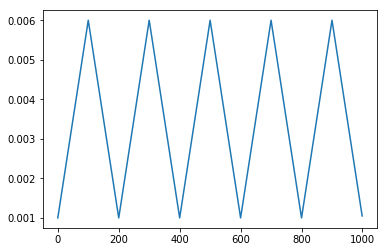

In [42]:
plt.plot(lr_history[:1000])

In [43]:
net.load_state_dict(best_weights)

In [44]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [47]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8992
